In [2]:
# JAX-compatible kite readout coupling module
import contextlib
import typing as _t
import warnings
from functools import partial
from typing import Any, Literal, Union, cast

import jax
from typing_extensions import NotRequired

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

# import jax.experimental.sparse as jsparse
import jax.numpy as jnp  # noqa: E402
import scipy.sparse.linalg as sp_linalg  # noqa: E402
from jax.scipy import linalg  # noqa: E402
from jax.scipy import special as jspecial  # noqa: E402
from scipy import constants as cst  # noqa: E402

In [3]:
# Set JAX to use double precision


# Physical constants
phi0 = cst.h / (2 * cst.e)
phi0bar = phi0 / (2 * jnp.pi)

# functions for converting units

backend1 = jax.devices("cpu")[0]
backend2 = jax.devices("cpu")[0]

# Type aliases for JAX arrays
_FloatScalar = float
Array = jnp.array
_Array = jnp.ndarray
_FloatOrArray = Union[float, jnp.ndarray]
_FloatOrArrayType = _FloatScalar | jnp.ndarray


# class DEFAULT_ARG:
#     pass


class ParamType(_t.TypedDict, total=True):
    ECs_GHz: float
    EJ_GHz: float
    eps: float
    ECJ_GHz: float
    EL_GHz: float
    ECc_GHz: float
    f_r_GHz: float
    nr_zpf: NotRequired[float]
    # z: float


DEFAULT_DIMS = (19, 32, 32, 5)
DEFAULT_PARAMS = {
    "ECs_GHz":0.072472,
    "EL_GHz":1.269,
    "ECJ_GHz":4.9895,
    "EJ_GHz":17.501,
    "eps":0.05702,
    "ECc_GHz":0.003989,
    "f_r_GHz":4.337,
}


class QubitParamType(_t.TypedDict, total=False):
    ECs_GHz: float
    EJ_GHz: float
    eps: float
    ECJ_GHz: float
    EL_GHz: float


@partial(jax.jit, device=backend1)
def conv_EC_to_capacitance(EC_GHz: _FloatOrArray) -> _FloatOrArray:  # units: GHz -> F
    """Convert charging energy to capacitance"""
    EC_J = EC_GHz * 1e9 * cst.h
    if hasattr(EC_J, "shape") and len(EC_J.shape) == 2:  # type: ignore
        return cst.e**2 / 2 * linalg.inv(EC_J)
    return cst.e**2 / (2 * EC_J)


@partial(jax.jit, device=backend1)
def conv_EL_to_inductance(EL_GHz: _FloatOrArray) -> _FloatOrArray:  # units: GHz -> H
    """Convert inductive energy to inductance"""
    EL_J = EL_GHz * 1e9 * cst.h
    if hasattr(EL_J, "shape") and len(EL_J.shape) == 2:  # type: ignore
        return phi0bar**2 * linalg.inv(EL_J)
    return phi0bar**2 / EL_J


@partial(jax.jit, device=backend1)
def conv_capacitance_to_EC(C_F: _FloatOrArray) -> _FloatOrArray:  # units: F -> GHz
    """Convert capacitance to charging energy"""
    if hasattr(C_F, "shape") and len(C_F.shape) == 2:  # type: ignore
        EC_J = cst.e**2 / 2 * linalg.inv(C_F)
    else:
        EC_J = cst.e**2 / (2 * C_F)
    return EC_J / (1e9 * cst.h)


@partial(jax.jit, device=backend1)
def conv_inductance_to_EL(L_H: _FloatOrArray) -> _FloatOrArray:  # units: H -> GHz
    """Convert inductance to inductive energy"""
    if hasattr(L_H, "shape") and len(L_H.shape) == 2:  # type: ignore
        EL_J = phi0bar**2 * linalg.inv(L_H)
    else:
        EL_J = phi0bar**2 / L_H
    return EL_J / (1e9 * cst.h)


@partial(jax.jit, device=backend1)
def get_phizpf(
    EC_GHz: _FloatOrArray, EL_GHz: _FloatOrArray
) -> _FloatOrArray:  # units: GHz, GHz -> 1
    """Calculate zero-point fluctuations from energies"""
    return (2 * EC_GHz / EL_GHz) ** 0.25


# ============================================================
# Sin and Cos matrix elements
# ============================================================


@partial(jax.jit, device=backend1)
def get_binom(x: jnp.ndarray, y: jnp.ndarray):
    return jnp.exp(
        jspecial.gammaln(x + 1) - jspecial.gammaln(y + 1) - jspecial.gammaln(x - y + 1)
    )


@partial(jax.jit, device=backend1)
def get_eval_genlaguerre(n: jnp.ndarray, alpha: jnp.ndarray, x: jnp.ndarray):
    d = get_binom(n + alpha, n)
    a = -n
    b = alpha + 1
    g = x
    return d * jspecial.hyp1f1(a, b, g)


@partial(jax.jit, device=backend1)
# matrix elements of cosines and sines in harmonic basis
def get_displacement_matrix(
    p: jnp.ndarray, i: jnp.ndarray, j: jnp.ndarray
) -> jnp.ndarray:
    """
    return <i|exp(i*p*(a + a_dag))|j>

    Glauber-Cahill formula for displacement with alpha = i*p
    """
    n, m = jnp.minimum(i, j), jnp.maximum(i, j)
    return (
        (1j) ** (m - n)
        / jnp.sqrt(jspecial.poch(n + 1, m - n))
        * p ** (m - n)
        * jnp.exp(-0.5 * p**2)
        * get_eval_genlaguerre(n, m - n, p**2)
    )


@partial(jax.jit, device=backend1)
def get_cosx(p: jnp.ndarray, i: jnp.ndarray, j: jnp.ndarray) -> jnp.ndarray:
    """return <i|cos(p*(a+a_dag))|j> = Re(<i|exp(i*p*(a+a_dag))|j>)"""
    return jnp.where((i - j) % 2 == 1, 0, jnp.real(get_displacement_matrix(p, i, j)))


@partial(jax.jit, device=backend1)
def get_sinx(p: jnp.ndarray, i: jnp.ndarray, j: jnp.ndarray) -> jnp.ndarray:
    return jnp.where((i - j) % 2 == 0, 0, jnp.imag(get_displacement_matrix(p, i, j)))


# ============================================================
# Matrixes in fock basis
# ============================================================
@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_identity(dim: int) -> jnp.ndarray:
    return jnp.eye(dim, dtype=complex)


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_number_operator(dim: int) -> jnp.ndarray:
    return jnp.diag(jnp.arange(dim, dtype=complex))


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_harmonic_hamiltonian(dim: int, f_GHz: float) -> jnp.ndarray:
    """<n|H|n> = freq*(n + 0.5)"""
    # return f_GHz * jnp.diag(jnp.array([n + 0.5 for n in range(dim)], dtype=complex))
    return f_GHz * jnp.diag(jnp.arange(dim, dtype=complex) + 0.5)


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_phi_operator(dim: int, phi_zpf: float) -> jnp.ndarray:
    """<i|phi|j> = phi_zpf * (a + a_dag)

    <j-1|a|j> = sqrt(j)
    <j+1|a_dag|j> = sqrt(j+1)

    """
    v = jnp.sqrt(jnp.arange(1, dim))
    return phi_zpf * (jnp.diag(v, 1) + jnp.diag(v, -1))


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_charge_operator(dim: int, phi_zpf: float) -> jnp.ndarray:
    """<i|charge_n|j> = i * 0.5 * (a_dag - a) / phi_zpf

    <j-1|a|j> = sqrt(j)
    <j+1|a_dag|j> = sqrt(j+1)

    """
    v = jnp.sqrt(jnp.arange(1, dim))
    return 1j * 0.5 * (jnp.diag(v, -1) - jnp.diag(v, 1)) / phi_zpf


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_cos_operator(dim: int, prefactor: float) -> jnp.ndarray:
    i = jnp.arange(dim)
    I, J = jnp.meshgrid(i, i, indexing="ij")
    return get_cosx(prefactor, I, J)


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def fock_basis_sin_operator(dim: int, prefactor: float) -> jnp.ndarray:
    i = jnp.arange(dim)
    I, J = jnp.meshgrid(i, i, indexing="ij")
    return get_sinx(prefactor, I, J)


# ============================================================
# Matrixes in charge basis
# ============================================================


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def charge_basis_identity(dim: int) -> jnp.ndarray:
    assert dim % 2 == 1, "dim must be odd"
    return jnp.eye(dim, dtype=complex)


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def charge_basis_harmonic_hamiltonian(dim: int, EC_GHz: float) -> jnp.ndarray:
    """<n|H|n> = 4 * EC_GHz * n**2"""
    assert dim % 2 == 1, "dim must be odd"
    dim_half = (dim - 1) // 2
    n = jnp.arange(-dim_half, dim_half + 1)
    return 4 * EC_GHz * jnp.diag((n**2).astype(complex))


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def charge_basis_charge_operator(dim: int) -> jnp.ndarray:
    """<n|n|n> = n"""
    assert dim % 2 == 1, "dim must be odd"
    dim_half = (dim - 1) // 2
    n = jnp.arange(-dim_half, dim_half + 1)
    return jnp.diag((n).astype(complex))


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def charge_basis_cos_operator(dim: int) -> jnp.ndarray:
    """<i|cos(phi)|j> = 0.5 if |i-j| = 1, 0 otherwise"""
    assert dim % 2 == 1, "dim must be odd"
    return 0.5 * (jnp.diag(jnp.ones(dim - 1), 1) + jnp.diag(jnp.ones(dim - 1), -1))


@partial(jax.jit, static_argnames=["dim"], device=backend1)
def charge_basis_sin_operator(dim: int) -> jnp.ndarray:
    """<j-1|sin(phi)|j> = 0.5 * 1j, <j+1|sin(phi)|j> = -0.5 * 1j, 0 otherwise"""
    assert dim % 2 == 1, "dim must be odd"
    return 0.5 * 1j * (jnp.diag(jnp.ones(dim - 1), 1) - jnp.diag(jnp.ones(dim - 1), -1))


# ============================================================
# EC and EL matrices from parameters
# ============================================================


@partial(jax.jit, device=backend1)
def get_EC_mat(
    ECs_GHz: float,
    eps: float,
    ECJ_GHz: float,
    ECc_GHz: float,
    nr_zpf: float,
    f_r_GHz: float,
    z: float = 0,
) -> jnp.ndarray:
    ECr_GHz = f_r_GHz / nr_zpf**2 / 16

    # Gauge phi, phi_sigma, phi_delta
    a00 = a01 = ECs_GHz
    a11 = 0.5 * ECJ_GHz / (1 - eps**2) + ECs_GHz
    a22 = 0.5 * ECJ_GHz / (1 - eps**2)
    a12 = -0.5 * ECJ_GHz * eps / (1 - eps**2)
    a33 = ECr_GHz
    a03 = a13 = ECc_GHz

    # Alvise gauge
    # EC_mat = np.zeros((4, 4))
    # EC_mat[0, 0] = ECJ_GHz * ECs_GHz / (ECJ_GHz + 2 * ECs_GHz)
    # EC_mat[1, 1] = ECJ_GHz / 2 + ECs_GHz
    # EC_mat[2, 2] = ECJ_GHz / 2
    # EC_mat[3, 3] = ECr_GHz
    # EC_mat[0, 3] = EC_mat[3, 0] = ECJ_GHz * ECc_GHz / (ECJ_GHz + 2 * ECs_GHz)
    # EC_mat[1, 3] = EC_mat[3, 1] = ECc_GHz

    # # General gauge
    # a00 = ECs_GHz * (1 - z) ** 2 + 0.5 * ECJ_GHz * z**2
    # a11 = 0.5 * ECJ_GHz / (1 - eps**2) + ECs_GHz
    # a22 = 0.5 * ECJ_GHz / (1 - eps**2)
    # a33 = ECr_GHz

    # a01 = ECs_GHz - z * (ECs_GHz + 0.5 * ECJ_GHz)
    # a03 = ECc_GHz * (1 - z)
    # a13 = ECc_GHz

    dtype = jnp.result_type(ECs_GHz, ECJ_GHz, ECr_GHz, ECc_GHz, z)
    return jnp.array(
        [
            [a00, a01, 0.0, a03],
            [a01, a11, a12, a13],
            [0.0, a12, a22, 0.0],
            [a03, a13, 0.0, a33],
        ],
        dtype=dtype,
    )


@partial(jax.jit, device=backend1)
def get_EL_mat(EL_GHz: float, nr_zpf: float, f_r_GHz: float) -> jnp.ndarray:
    EL_r = 2 * f_r_GHz * nr_zpf**2

    return jnp.diag(jnp.array([0, 2 * EL_GHz, 2 * EL_GHz, EL_r], dtype=jnp.float64))


class HamiltonianOps(_t.NamedTuple):
    H0: _Array
    H1: _Array
    H2: _Array
    H_r: _Array
    I0: _Array
    I1: _Array
    I2: _Array
    N0: _Array
    N1: _Array
    N2: _Array
    N_r: _Array
    C0: _Array
    C1: _Array
    C2: _Array
    S0: _Array
    S1: _Array
    S2: _Array
    EC_mat: _Array
    EL_mat: _Array
    phi_r_zpf: _Array
    EJ_GHz: float
    eps: float


# @partial(jax.jit, static_argnames=("dim",), device=backend1)
def build_static_operators(
    dims: tuple[int, int, int, int],
    ECs_GHz: float,
    EL_GHz: float,
    ECJ_GHz: float,
    EJ_GHz: float,
    eps: float,
    ECc_GHz: float = 0,
    f_r_GHz: float = 4.4,
    nr_zpf: float = 2,
    # z: float = 0,
) -> HamiltonianOps:
    """
    operators_to_return = [
        [Zq, Zr, [Zq, Zr]],  # static
        [Zq, Zr],  # couple to Ng
        [Zq, Zr],  # couple to cos(phiext / 2)
        [Zq, Zr],  # couple to sin(phiext / 2)
    ]
    """
    # build capacitance and inductance matrices
    # C_mat = capacitance_matrix(parameters)
    # L_inv_mat = inverse_inductance_matrix(parameters)

    # change gauge
    # ECJ_GHz = parameters["ECJ_GHz"]
    # ECs_GHz = parameters["ECs_GHz"]

    # get mode frequencies and zpfs
    EC_mat = get_EC_mat(
        ECs_GHz=ECs_GHz,
        eps=eps,
        ECJ_GHz=ECJ_GHz,
        ECc_GHz=ECc_GHz,
        nr_zpf=nr_zpf,
        f_r_GHz=f_r_GHz,
        # z=z,
    )
    EL_mat = get_EL_mat(
        EL_GHz=EL_GHz,
        nr_zpf=nr_zpf,
        f_r_GHz=f_r_GHz,
    )

    EC_vec = jnp.diagonal(EC_mat)
    EL_vec = jnp.diagonal(EL_mat)

    # EC_vec[1] = ECs_GHz

    # f_r_GHz = parameters["fr_GHz"]
    freqs = jnp.sqrt(8 * EC_vec[1:3] * EL_vec[1:3])
    f_1_GHz, f_2_GHz = freqs[0], freqs[1]

    phizpfs_arr = get_phizpf(EC_GHz=EC_vec[1:], EL_GHz=EL_vec[1:])
    phi_1_zpf, phi_2_zpf, phi_r_zpf = phizpfs_arr[0], phizpfs_arr[1], phizpfs_arr[2]
    # Variable 0
    I0 = charge_basis_identity(dims[0])
    H0 = charge_basis_harmonic_hamiltonian(dims[0], EC_vec[0])
    N0 = charge_basis_charge_operator(dims[0])
    C0 = charge_basis_cos_operator(dims[0])
    S0 = charge_basis_sin_operator(dims[0])

    # Variable 1
    z_tilde = 1  # - z
    I1 = fock_basis_identity(dims[1])
    H1 = fock_basis_harmonic_hamiltonian(dims[1], cast(float, f_1_GHz))
    N1 = fock_basis_charge_operator(dims[1], phi_zpf=phi_1_zpf)
    C1 = fock_basis_cos_operator(dims[1], prefactor=z_tilde * phi_1_zpf)
    S1 = fock_basis_sin_operator(dims[1], prefactor=z_tilde * phi_1_zpf)

    # Variable 2
    I2 = fock_basis_identity(dims[2])
    H2 = fock_basis_harmonic_hamiltonian(dims[2], cast(float, f_2_GHz))
    N2 = fock_basis_charge_operator(dims[2], phi_zpf=phi_2_zpf)
    C2 = fock_basis_cos_operator(dims[2], prefactor=phi_2_zpf)
    S2 = fock_basis_sin_operator(dims[2], prefactor=phi_2_zpf)

    # Resonator variable
    H_r = fock_basis_harmonic_hamiltonian(dims[3], cast(float, f_r_GHz))
    N_r = fock_basis_charge_operator(dims[3], phi_zpf=phi_r_zpf)

    return HamiltonianOps(
        H0=H0,
        H1=H1,
        H2=H2,
        H_r=H_r,
        I0=I0,
        I1=I1,
        I2=I2,
        N0=N0,
        N1=N1,
        N2=N2,
        N_r=N_r,
        C0=C0,
        C1=C1,
        C2=C2,
        S0=S0,
        S1=S1,
        S2=S2,
        EC_mat=EC_mat,
        EL_mat=EL_mat,
        phi_r_zpf=phi_r_zpf,
        EJ_GHz=EJ_GHz,
        eps=eps,
    )


# @partial(jax.jit, static_argnames=["axes"])
# def apply_tensor_product(axes: int, H: jnp.ndarray, V: jnp.ndarray):
#     V = jnp.swapaxes(V, axes, -1)
#     T = jnp.matvec(H, V)
#     T = jnp.swapaxes(T, -1, axes)
#     return T


@partial(jax.jit, static_argnames=["axes"])
def apply_tensor_product(axes: int, H: jnp.ndarray, V: jnp.ndarray):
    selected_axes_len = V.shape[axes]
    V = jnp.swapaxes(V, axes, 0)
    shape = V.shape
    V = jnp.reshape(V, (selected_axes_len, -1))
    T = H @ V
    T = jnp.reshape(T, shape)
    return jnp.swapaxes(T, 0, axes)


# @partial(jax.jit, static_argnames=["axes"])
# def apply_tensor_product(axes: int, H: jnp.ndarray, V: jnp.ndarray):
#     # print(V.shape)
#     V = jnp.swapaxes(V, axes, -1)
#     # print(V.shape)
#     # print(H.shape, V.shape)
#     T = jnp.dot(V, H)
#     # print(T.shape)
#     T = T.swapaxes(-1, axes)
#     # T = jnp.moveaxis(T, , axes)
#     # print(T.shape)
#     return T


@partial(jax.jit, static_argnames=["dims"], device=backend2)
def apply_q_hamitonian_to_vec(
    ops: HamiltonianOps,
    dims: tuple[int, int, int],
    vec: jnp.ndarray,
    n_g: float,
    phiext: float,
) -> jnp.ndarray:
    batches = vec.shape[1]
    cal_space = vec.shape[0]

    # static terms
    R = jnp.zeros((*dims, batches), dtype=jnp.complex128)
    V = vec.reshape((*dims, batches))

    # ============= Static terms =============
    # ∑_i 4 EC_ii N_i**2 + ∑_i EL_ii φ_i**2/2 = ∑_i H_i
    R += apply_tensor_product(0, ops.H0, V)
    R += apply_tensor_product(1, ops.H1, V)
    R += apply_tensor_product(2, ops.H2, V)

    # ∑_i≠j 4 EC_ij N_i N_j = ∑_i>j 8 EC_ij N_i N_j for i, j ∈ {0, 1, 2}
    # if jnp.abs(EC_mat[0, 1]) > threshold:
    R += (
        8
        * ops.EC_mat[0, 1]
        * apply_tensor_product(0, ops.N0, apply_tensor_product(1, ops.N1, V))
    )
    # if jnp.abs(EC_mat[0, 2]) > threshold:
    # No coupling
    # R += (
    #     8
    #     * ops.EC_mat[0, 2]
    #     * apply_tensor_product(0, ops.N0, apply_tensor_product(2, ops.N2, V))
    # )
    # if jnp.abs(EC_mat[1, 2]) > threshold:
    # No coupling
    R += (
        8
        * ops.EC_mat[1, 2]
        * apply_tensor_product(1, ops.N1, apply_tensor_product(2, ops.N2, V))
    )

    # ============= Coupling to Ng =============
    # - ∑_j 8 n_g EC_0j N_j for j ∈ {0, 1, 2}
    R += -8 * ops.EC_mat[0, 0] * apply_tensor_product(0, ops.N0, V) * n_g
    # if jnp.abs(EC_mat[0, 1]) > threshold:
    R += -8 * ops.EC_mat[0, 1] * apply_tensor_product(1, ops.N1, V) * n_g
    # if jnp.abs(EC_mat[0, 2]) > threshold:
    # No coupling
    # R += -8 * ops.EC_mat[0, 2] * apply_tensor_product(2, ops.N2, V) * n_g

    # ============= Coupling to cos(phiext / 2) =============
    # terms that go with cos(phiext / 2)
    R += (
        -2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.C2, V)),
        )
        - 2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.C2, V)),
        )
        - 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.S2, V)),
        )
        + 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.S2, V)),
        )
    ) * jnp.cos(0.5 * phiext)

    # ============= Coupling to sin(phiext / 2) =============
    # terms that go with sin(phiext / 2)
    R += (
        +2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.S2, V)),
        )
        + 2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.S2, V)),
        )
        - 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.C2, V)),
        )
        + 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.C2, V)),
        )
    ) * jnp.sin(0.5 * phiext)

    return jnp.reshape(R, (cal_space, batches))


@partial(jax.jit, static_argnames=("dims", "n_g", "phiext"), device=backend1)
def apply_qr_hamitonian_to_vec(
    ops: HamiltonianOps,
    dims: tuple[int, int, int, int],
    vec: jnp.ndarray,
    n_g: float,
    phiext: float,
) -> jnp.ndarray:
    # print(vec.shape)
    batches = vec.shape[1]
    cal_space = vec.shape[0]

    # static terms
    R = jnp.zeros((*dims, batches))
    V = vec.reshape((*dims, batches))
    # print(V.shape)

    # ============= Static terms =============
    # ∑_i 4 EC_ii N_i**2 + ∑_i EL_ii φ_i**2/2 = ∑_i H_i
    R += apply_tensor_product(0, ops.H0, V)
    R += apply_tensor_product(1, ops.H1, V)
    R += apply_tensor_product(2, ops.H2, V)

    # ∑_i≠j 4 EC_ij N_i N_j = ∑_i>j 8 EC_ij N_i N_j for i, j ∈ {0, 1, 2}
    # if jnp.abs(EC_mat[0, 1]) > threshold:
    R += (
        8
        * ops.EC_mat[0, 1]
        * apply_tensor_product(0, ops.N0, apply_tensor_product(1, ops.N1, V))
    )
    # if jnp.abs(EC_mat[0, 2]) > threshold:
    # No coupling
    # R += (
    #     8
    #     * ops.EC_mat[0, 2]
    #     * apply_tensor_product(0, ops.N0, apply_tensor_product(2, ops.N2, V))
    # )
    # if jnp.abs(EC_mat[1, 2]) > threshold:
    # No coupling
    R += (
        8
        * ops.EC_mat[1, 2]
        * apply_tensor_product(1, ops.N1, apply_tensor_product(2, ops.N2, V))
    )

    # ============= Coupling to Ng =============
    # - ∑_j 8 n_g EC_0j N_j for j ∈ {0, 1, 2}
    R += -8 * ops.EC_mat[0, 0] * apply_tensor_product(0, ops.N0, V) * n_g
    # if jnp.abs(EC_mat[0, 1]) > threshold:
    R += -8 * ops.EC_mat[0, 1] * apply_tensor_product(1, ops.N1, V) * n_g
    # if jnp.abs(EC_mat[0, 2]) > threshold:
    # No coupling
    # R += -8 * ops.EC_mat[0, 2] * apply_tensor_product(2, ops.N2, V) * n_g

    # ============= Coupling to cos(phiext / 2) =============
    # terms that go with cos(phiext / 2)
    R += (
        -2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.C2, V)),
        )
        - 2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.C2, V)),
        )
        - 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.S2, V)),
        )
        + 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.S2, V)),
        )
    ) * jnp.cos(0.5 * phiext)

    # ============= Coupling to sin(phiext / 2) =============
    # # terms that go with sin(phiext / 2)
    R += (
        +2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.S2, V)),
        )
        + 2
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.S2, V)),
        )
        - 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.S0,
            apply_tensor_product(1, ops.C1, apply_tensor_product(2, ops.C2, V)),
        )
        + 2
        * ops.eps
        * ops.EJ_GHz
        * apply_tensor_product(
            0,
            ops.C0,
            apply_tensor_product(1, ops.S1, apply_tensor_product(2, ops.C2, V)),
        )
    ) * jnp.sin(0.5 * phiext)

    # ============= Readout static terms =============
    R += apply_tensor_product(3, ops.H_r, V)
    # ============= Resonator coupling to Ng =============
    R += -8 * ops.EC_mat[0, 3] * apply_tensor_product(3, ops.N_r, V) * n_g
    # ============= Resonator-qubit coupling =============
    # ∑_i 8 EC_i3 N_i N_3 for i ∈ {0, 1, 2}

    R += (
        8
        * ops.EC_mat[0, 3]
        * apply_tensor_product(0, ops.N0, apply_tensor_product(3, ops.N_r, V))
    ) + (
        8
        * ops.EC_mat[1, 3]
        * apply_tensor_product(1, ops.N1, apply_tensor_product(3, ops.N_r, V))
    )
    #     # + (
    #     #     8
    #     #     * ops.EC_mat[2, 3] # no coupling to N2
    #     #     * apply_tensor_product(2, ops.N2, apply_tensor_product(3, ops.N_r, V))
    #     # )
    # )

    return jnp.reshape(R, (cal_space, batches))


@jax.jit
def sort_levels_ascending(
    ev: jnp.ndarray, ek: jnp.ndarray | None = None
) -> jnp.ndarray | tuple[jnp.ndarray, jnp.ndarray]:
    """Sort eigenvalues and eigenvectors in ascending order"""
    idx = jnp.argsort(ev, descending=False)
    if ek is None:
        return ev[idx]
    return ev[idx], ek[:, idx]


def get_q_esys_from_ops(
    ops: HamiltonianOps,
    dims: tuple[int, int, int],
    dim_kept: int,
    n_g: float,
    phiext: float,
    ek_previous: jnp.ndarray | None = None,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    def mv(v):
        return apply_q_hamitonian_to_vec(
            ops, dims, v[:, jnp.newaxis], n_g=n_g, phiext=phiext
        )

    def mm(v):
        return apply_q_hamitonian_to_vec(ops, dims, v, n_g=n_g, phiext=phiext)

    total_dim = dims[0] * dims[1] * dims[2]
    lin_op = sp_linalg.LinearOperator(
        shape=(total_dim, total_dim),
        matvec=mv,  # type: ignore
        matmat=mm,  # type: ignore
        dtype=jnp.complex128,
    )

    ret = None
    if ek_previous is not None:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            with contextlib.suppress(UserWarning):
                ret = sp_linalg.lobpcg(lin_op, ek_previous, maxiter=40, largest=False)
    if ret is None:
        ret = sp_linalg.eigsh(lin_op, dim_kept, which="SR")

    ev_q_v, ek_q_v = sort_levels_ascending(ret[0].real, ret[1])
    return ev_q_v, ek_q_v


def get_q_esys_with_jac_single_direction(
    dims: tuple[int, int, int],
    params: QubitParamType,
    param_name: str,
    ek_center: jnp.ndarray,
    n_g: float,
    phiext: float,
) -> jnp.ndarray:
    delta: float = max(params[param_name] * 1e-4, 1e-4)
    params_1: QubitParamType = params | {param_name: params[param_name] + delta}  # type: ignore
    params_2: QubitParamType = params | {param_name: params[param_name] - delta}  # type: ignore
    ops_plus: HamiltonianOps = build_static_operators((*dims[:3], 0), **params_1)
    ev_plus: jnp.ndarray = linalg.eigh(
        ek_center.conj().T
        @ apply_q_hamitonian_to_vec(
            ops_plus, dims=dims[:3], vec=ek_center, n_g=n_g, phiext=phiext
        )
    )[0]
    ops_minus: HamiltonianOps = build_static_operators((*dims[:3], 0), **params_2)
    ev_minus: jnp.ndarray = linalg.eigh(
        ek_center.conj().T
        @ apply_q_hamitonian_to_vec(
            ops_minus, dims=dims[:3], vec=ek_center, n_g=n_g, phiext=phiext
        )
    )[0]
    return (ev_plus - ev_minus) / (2 * delta)


def get_q_esys_with_jac(
    dims: tuple[int, int, int],
    dim_kept: int,
    n_g: float,
    phiext: float,
    ECs_GHz: float,
    EL_GHz: float,
    ECJ_GHz: float,
    EJ_GHz: float,
    eps: float,
    ek_previous: jnp.ndarray | None = None,
) -> tuple[
    jnp.ndarray,
    jnp.ndarray,
    jnp.ndarray,
    # tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],
]:
    ops = build_static_operators(
        (*dims[:3], 0),
        ECs_GHz=ECs_GHz,
        EL_GHz=EL_GHz,
        ECJ_GHz=ECJ_GHz,
        EJ_GHz=EJ_GHz,
        eps=eps,
    )
    ev_center, ek_center = get_q_esys_from_ops(
        ops, dims, dim_kept, n_g, phiext, ek_previous=ek_previous
    )
    params: QubitParamType = {
        "ECs_GHz": ECs_GHz,
        "EJ_GHz": EJ_GHz,
        "eps": eps,
        "ECJ_GHz": ECJ_GHz,
        "EL_GHz": EL_GHz,
    }
    jac_ECs = get_q_esys_with_jac_single_direction(
        dims, params, "ECs_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    )
    jac_EL = get_q_esys_with_jac_single_direction(
        dims, params, "EL_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    )
    jac_ECJ = get_q_esys_with_jac_single_direction(
        dims, params, "ECJ_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    )
    jac_EJ = get_q_esys_with_jac_single_direction(
        dims, params, "EJ_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    )
    jac_eps = get_q_esys_with_jac_single_direction(
        dims, params, "eps", ek_center=ek_center, n_g=n_g, phiext=phiext
    )
    return (
        ev_center,
        ek_center,
        jnp.stack((jac_ECs, jac_EL, jac_ECJ, jac_EJ, jac_eps), axis=0),
    )


def get_qr_esys_from_ops(
    ops: HamiltonianOps,
    dims: tuple[int, int, int, int],
    dim_kept: int,
    n_g: float,
    phiext: float,
    ek_previous: jnp.ndarray | None = None,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    @jax.jit
    def mv(v: jnp.ndarray) -> jnp.ndarray:
        return apply_qr_hamitonian_to_vec(
            ops, dims, v[:, jnp.newaxis], n_g=n_g, phiext=phiext
        )

    @jax.jit
    def mm(m: jnp.ndarray) -> jnp.ndarray:  # m.s
        return apply_qr_hamitonian_to_vec(ops, dims, m, n_g=n_g, phiext=phiext)

    total_dim = dims[0] * dims[1] * dims[2] * dims[3]
    lin_op = sp_linalg.LinearOperator(
        shape=(total_dim, total_dim),
        matvec=mv,  # type: ignore
        matmat=mm,  # type: ignore
        dtype=jnp.complex128,
    )

    ret = None
    if ek_previous is not None:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            with contextlib.suppress(UserWarning):
                ret = sp_linalg.lobpcg(lin_op, ek_previous, maxiter=40, largest=False)
    if ret is None:
        ret = sp_linalg.eigsh(lin_op, dim_kept, which="SR")

    ev_q_v, ek_q_v = sort_levels_ascending(ret[0].real, ret[1])
    # ev_q_v -= ev_q_v[0]
    return ev_q_v, ek_q_v


def get_qr_esys_with_jac_single_direction(
    dims: tuple[int, int, int, int],
    params: ParamType,
    param_name: str,
    ek_center: jnp.ndarray,
    n_g: float,
    phiext: float,
) -> jnp.ndarray:
    # Here we suppose that the following small change in the parameter
    # would not change the branch.
    delta: float = max(params[param_name] * 1e-4, 1e-4)
    params_1: ParamType = params | {param_name: params[param_name] + delta}  # type: ignore
    params_2: ParamType = params | {param_name: params[param_name] - delta}  # type: ignore
    ops_plus: HamiltonianOps = build_static_operators(dims, **params_1)
    ev_plus: jnp.ndarray = linalg.eigh(
        ek_center.conj().T
        @ apply_qr_hamitonian_to_vec(
            ops_plus, dims=dims, vec=ek_center, n_g=n_g, phiext=phiext
        )
    )[0]
    ops_minus: HamiltonianOps = build_static_operators(dims, **params_2)
    ev_minus: jnp.ndarray = linalg.eigh(
        ek_center.conj().T
        @ apply_qr_hamitonian_to_vec(
            ops_minus, dims=dims, vec=ek_center, n_g=n_g, phiext=phiext
        )
    )[0]
    return (ev_plus - ev_minus) / (2 * delta)


def get_qr_esys_with_jac(
    dims: tuple[int, int, int, int],
    dim_kept: int,
    n_g: float,
    phiext: float,
    ECs_GHz: float,
    EL_GHz: float,
    ECJ_GHz: float,
    EJ_GHz: float,
    eps: float,
    ECc_GHz: float,
    f_r_GHz: float,
    nr_zpf: float = 2,
    ek_previous: jnp.ndarray | None = None,
    output_jac_params: tuple[str, ...] | None | Literal["all"] = "all",
) -> tuple[
    jnp.ndarray,
    jnp.ndarray,
    jnp.ndarray,
    # tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],
]:
    ops = build_static_operators(
        dims,
        ECs_GHz=ECs_GHz,
        EL_GHz=EL_GHz,
        ECJ_GHz=ECJ_GHz,
        EJ_GHz=EJ_GHz,
        eps=eps,
        ECc_GHz=ECc_GHz,
        f_r_GHz=f_r_GHz,
        nr_zpf=nr_zpf,
    )
    ev_center, ek_center = get_qr_esys_from_ops(
        ops, dims, dim_kept, n_g, phiext, ek_previous=ek_previous
    )
    params: ParamType = {
        "ECs_GHz": ECs_GHz,
        "EJ_GHz": EJ_GHz,
        "eps": eps,
        "ECJ_GHz": ECJ_GHz,
        "EL_GHz": EL_GHz,
        "ECc_GHz": ECc_GHz,
        "f_r_GHz": f_r_GHz,
        "nr_zpf": nr_zpf,
    }
    if output_jac_params == "all":
        output_jac_params = (
            "ECs_GHz",
            "EL_GHz",
            "ECJ_GHz",
            "EJ_GHz",
            "eps",
            "ECc_GHz",
            "f_r_GHz",
        )
    if output_jac_params is None or len(output_jac_params) == 0:
        return (ev_center, ek_center, jnp.array([]))

    jacs = [
        get_qr_esys_with_jac_single_direction(
            dims, params, param, ek_center=ek_center, n_g=n_g, phiext=phiext
        )
        for param in output_jac_params
    ]

    # jac_ECs = get_qr_esys_with_jac_single_direction(
    #     dims, params, "ECs_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_EL = get_qr_esys_with_jac_single_direction(
    #     dims, params, "EL_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_ECJ = get_qr_esys_with_jac_single_direction(
    #     dims, params, "ECJ_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_EJ = get_qr_esys_with_jac_single_direction(
    #     dims, params, "EJ_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_eps = get_qr_esys_with_jac_single_direction(
    #     dims, params, "eps", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_ECc = get_qr_esys_with_jac_single_direction(
    #     dims, params, "ECc_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    # jac_f_r = get_qr_esys_with_jac_single_direction(
    #     dims, params, "f_r_GHz", ek_center=ek_center, n_g=n_g, phiext=phiext
    # )
    return (ev_center, ek_center, jnp.stack(jacs, axis=0))


@partial(jax.jit, static_argnames=["dim_q_total", "dim_readout"])
def evaluate_expected_resonator_number(
    ek: jnp.ndarray, dim_q_total: int, dim_readout: int
) -> jnp.ndarray:
    """
    Evaluate the expected resonator number for a given set of eigenvectors.
    """
    readout_number_operator = fock_basis_number_operator(dim_readout)
    return (
        jnp.diag(
            jnp.real(
                ek.conj().T
                @ apply_tensor_product(
                    1,
                    readout_number_operator,
                    ek.reshape((dim_q_total, dim_readout, -1)),
                ).reshape((dim_q_total * dim_readout, -1))
            )
        )
        .round()
        .astype(int)
    )


# @jax.jit
def tuple_index_to_flatten(
    index_q: int, index_r: int, expected_resonator_number: jnp.ndarray
) -> int:
    return int(jnp.flatnonzero(expected_resonator_number == index_r)[index_q])


# Computing a Hamiltonian

In [4]:
dims = (9,16,16,5)
ops = build_static_operators(dims,**DEFAULT_PARAMS)

In [5]:
Energies,Psi = get_qr_esys_from_ops(ops, dims, 4, 0.5, 0.5)
Energies - Energies[0]

Array([0.        , 1.20402658, 2.51235131, 3.96540407], dtype=float64)

# Computing the variances

In [6]:
%load_ext autoreload
%autoreload 2

import kite_spectrum_jax_vec as vkite
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:

def compute_energy_variances(
    ops: HamiltonianOps,
    dims: tuple[int, int, int, int],
    ev:np.ndarray,
    ek:np.ndarray,
    n_g: float,
    phiext: float
) -> jnp.ndarray:
    
    h_psi = apply_qr_hamitonian_to_vec(ops, dims, ek, n_g=n_g, phiext=phiext)
    E2 = jnp.sum(jnp.conj(h_psi) * h_psi, axis=0).real
    
    variance = abs(E2 - ev**2)
    
    return variance

In [40]:
flux_tabs = np.linspace(0, 1.0, 9)
n_states = 4
n_g = 0.5
dims = (9,16,16,5)
ops = build_static_operators(dims,**DEFAULT_PARAMS)

In [41]:
ev_tab = np.zeros((len(flux_tabs), n_states))
ek_tab = np.zeros(
    (len(flux_tabs), np.prod(dims), n_states), dtype=jnp.complex128
)
variances_python = np.zeros((len(flux_tabs), n_states))
for i, flux in enumerate(tqdm(flux_tabs)):
    ev, ek = get_qr_esys_from_ops(
        ops = ops,
        dims=dims,
        dim_kept=n_states,
        n_g=n_g,
        phiext=float(flux),
    )
    ev_tab[i] = ev
    ek_tab[i] = ek
    variances_python[i] = compute_energy_variances(ops, dims, ev, ek, n_g, float(flux))


  0%|          | 0/9 [00:00<?, ?it/s]

In [45]:
import pandas as pd

df = pd.read_csv('variances/all_sigmas.csv')
data = df.to_numpy()
variances_julia = data[:, 1:]

In [46]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

[Text(0.5, 1.0, 'Variance of the 4 first energy levels, Julia VS JAX/Python'),
 Text(0.5, 0, '$\\varphi_{\\mathrm{ext}}$'),
 Text(0, 0.5, 'Variance'),
 None]

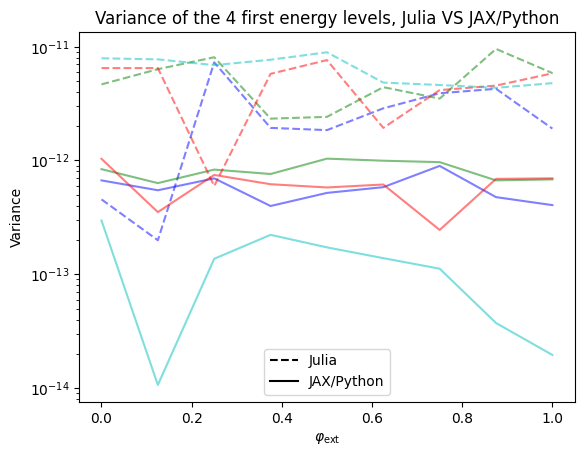

In [47]:
Colors = ["b", "g", "r", "c", "m", "y"]

fig, ax = plt.subplots()

for i in range(n_states):
    ax.plot(flux_tabs, variances_julia[:, i], linestyle="--", c=Colors[i], alpha=0.5)
    ax.plot(flux_tabs, variances_python[:, i], linestyle="-", c=Colors[i], alpha=0.5)


ax.legend(
    handles=[
        mlines.Line2D([], [], color="black", linestyle="--", label="Julia"),
        mlines.Line2D([], [], color="black", linestyle="-", label="JAX/Python"),
    ]
)

ax.set(
    title=f"Variance of the {n_states} first energy levels, Julia VS JAX/Python",
    xlabel=r'$\varphi_{\mathrm{ext}}$',
    ylabel="Variance",
    yscale = "log"
)

# Checks to see if both Hamiltonians are the same

In [ ]:
@partial(jax.jit, static_argnames=["dims", "n_g"])
def get_qr_hamiltonian_matrix(
    ops: HamiltonianOps, 
    dims: tuple[int, int, int, int], 
    n_g: float, 
    phiext: float
) -> jnp.ndarray:
    total_dim = dims[0] * dims[1] * dims[2] * dims[3]
    identity = jnp.eye(total_dim, dtype=jnp.complex128)
    
    Hmat = apply_qr_hamitonian_to_vec(ops, dims, identity, n_g, phiext)

    d0, d1, d2, d3 = dims
    H_tensor = Hmat.reshape(d0, d1, d2, d3, d0, d1, d2, d3)
    
    #Reverse order to match the Julia implementation (column-major vs row-major)
    H_reversed = jnp.transpose(H_tensor, (3, 2, 1, 0, 7, 6, 5, 4))
    return H_reversed.reshape(d0*d1*d2*d3, -1)

In [ ]:
import pandas as pd

def load_julia_csv(filename):
    df = pd.read_csv(filename, dtype=str)
    def to_complex(s):
        if pd.isna(s): return 0j
        return complex(s.replace('im', 'j').replace(' ', ''))
    matrix = df.map(to_complex).to_numpy()
    return matrix

In [ ]:
Hmat_julia = load_julia_csv("test_ops/kite_hamiltonian_array_julia")

In [ ]:
import numpy as np

In [ ]:
(~(H_mat - Hmat_julia < 1e-10)).nonzero()

(Array([], shape=(0,), dtype=int64), Array([], shape=(0,), dtype=int64))

In [ ]:
def load_op(name):
    re = pd.read_csv(f"test_ops\\{name}_real.csv").to_numpy()
    im = pd.read_csv(f"test_ops\\{name}_imag.csv").to_numpy()
    return jnp.array(re + 1j * im)

In [ ]:
np.isclose(ops.C1, load_op("C1"), atol=1e-12)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])